In [1]:
import os
from albumentations import *

import segmentation_models as sm
import cv2
import numpy as np 

import pandas as pd
import tensorflow as tf

import keras
from keras.optimizers import *
from keras import backend as K
from keras import Input
from keras.models import Model
from keras.callbacks import *
from keras.metrics import *
from keras.utils import *

from tensorflow import set_random_seed
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\quand\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\quand\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\quand\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\quand\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

Segmentation Models: using `keras` framework.


In [2]:
'''
    Training config
'''
IMG_SIZE = (256, 256, 3)
EPOCHS = 50
BATCH_SIZE = 16
MODEL_NAME = 'resnet34'

TRAINING_IMAGE_FOLDER = '../data/stage1_train'
TRAINING_CSV = '../data/stage1_train_labels.csv'

generator = Compose([
                    HorizontalFlip(),
                    VerticalFlip(),
                    ShiftScaleRotate(),
                    OneOf([
                        RandomBrightness(),
                        RandomContrast(),
                        RandomGamma(),
                        CLAHE()
                    ])], 
            additional_targets={'mask': 'mask'})

In [3]:
train_df = pd.read_csv(TRAINING_CSV)

In [4]:
'''
    RLE Utilities functions
'''
def rle_encoding(mask):
    
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels,[0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    if len(runs) % 2:
        runs = np.append(runs,len(pixels))
    runs[1::2] -= runs[0::2]
    
    return ' '.join(str(x) for x in runs)

def rle_decoding(rle, mask_shape = (256,256)):
    strs = rle.split(' ')
    starts = np.asarray(strs[0::2], dtype = int) - 1
    lengths = np.asarray(strs[1::2], dtype = int)
    ends = starts + lengths
    
    mask = np.zeros(mask_shape[0] * mask_shape[1], dtype = np.uint8)
    for s,e in zip(starts, ends):
        mask[s:e] = 1
    return mask.reshape((mask_shape[0], mask_shape[1]), order = 'F')

In [5]:
'''
    Metric and loss function
'''
def Dice_Coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 2*intersection / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def Dice_Loss(y_true, y_pred):
    return 1 - Dice_Coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true, y_pred) + Dice_Loss(y_true, y_pred)

In [6]:
class Datagen(Sequence):
    def __init__(self, list_id, image_folder, generator = None, batch_size=BATCH_SIZE):
        self.list_id = list_id
        self.image_folder = image_folder
        self.generator = generator
        self.batch_size = batch_size
        
    def on_epoch_end(self):
        np.random.shuffle(self.list_id)
        
    def __len__(self):
        return int(np.floor(len(self.list_id) / self.batch_size)) 
        
    def __getitem__(self, index):
        list_id = self.list_id[index*self.batch_size:(index + 1)*self.batch_size]
        images = np.empty((len(list_id), *IMG_SIZE), dtype=np.uint8)
        masks = np.empty((len(list_id), IMG_SIZE[0], IMG_SIZE[1], 1), dtype=np.uint8)
        for i, item in enumerate(list_id):
            path = os.path.join(self.image_folder, item)
            image_path = os.path.join(path, 'images', item + '.png') 
            image = cv2.imread(image_path)
            image = cv2.resize(image, (IMG_SIZE[1], IMG_SIZE[0]))
            images[i] = image
            
            masks_path = os.path.join(path, 'masks')
            masks_file = os.listdir(masks_path)
            for mask in masks_file:
                mask_img = cv2.imread(os.path.join(masks_path, mask), cv2.IMREAD_GRAYSCALE)
                mask_img = cv2.resize(mask_img, (IMG_SIZE[1], IMG_SIZE[0]))
                masks[i,:,:,0] += mask_img
                
            if self.generator is not None:
                for i in range(len(list_id)):
                    augmented = self.generator(image=images[i], mask=masks[i])
                    images[i] = augmented['image']
                    masks[i] = augmented['mask']
                
        return images.astype(np.float32) / 255., masks.astype(np.float32) / 255.

In [7]:
list_item = os.listdir(TRAINING_IMAGE_FOLDER)
from sklearn.model_selection import train_test_split
train_list, test_list = train_test_split(list_item, test_size=0.1)
train_gen = Datagen(train_list, TRAINING_IMAGE_FOLDER, generator)
valid_gen = Datagen(test_list, TRAINING_IMAGE_FOLDER)

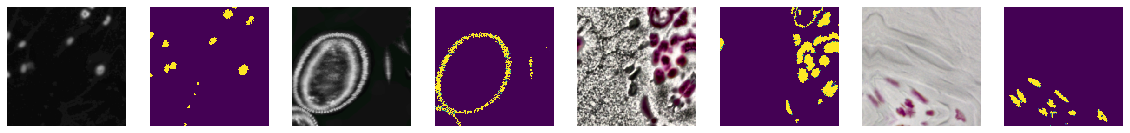

In [8]:
img, mask = train_gen.__getitem__(0)
img = img*255.
img = img.astype('uint8')
mask = mask.reshape(BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1])
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(20,4))
i = 0
while i < 8:
    ax[i].imshow(img[i])
    ax[i + 1].imshow(mask[i])
    ax[i].axis('off')
    ax[i + 1].axis('off')
    i += 2

In [9]:
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_Dice_Coef',
                                               mode='max',
                                               verbose=1,
                                               patients=10,
                                               min_lr=1e-5),
             keras.callbacks.ModelCheckpoint('../data/resnet34.h5',
                                         monitor='val_Dice_Coef', 
                                         verbose=1, 
                                         save_best_only=True, 
                                         save_weights_only=True, 
                                         mode='max', 
                                         period=1)]

model = sm.Unet(MODEL_NAME, input_shape=IMG_SIZE, classes=1, activation='sigmoid')

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[Dice_Coef])
model.fit_generator(train_gen, 
                    steps_per_epoch=len(train_gen),
                    epochs=EPOCHS,
                    validation_data=valid_gen,
                    validation_steps=len(valid_gen),
                    callbacks=callbacks)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
37/37 [==============================] - 38s 1s/step - loss: 0.9956 - Dice_Coef: 0.4389 - val_loss: 0.7218 - val_Dice_Coef: 0.5357

Epoch 00001: val_Dice_Coef improved from -inf to 0.53565, saving model to ../data/resnet34.h5
Epoch 2/50
37/37 [==============================] - 23s 627ms/step - loss: 0.4524 - Dice_Coef: 0.7009 - val_loss: 0.4252 - val_Dice_Coef: 0.7115

Epoch 00002: val_Dice_Coef improved from 0.53565 to 0.71150, saving model to ../data/resnet34.h5
Epoch 3/50
37/37 [==============================] - 32s 869ms/step - loss: 0.3437 - Dice_Coef: 0.7829 - val_loss: 0.4485 - val_Dice_Coef: 0.6976

Epoch 00003: val_Dice_Coef did not improve from 0.71150
Epoch 4/50
37/37 [==============================] - 33s 893ms/step - loss: 0.3321 - Dice_Coef: 0.7952 - val_loss: 0.4058 - val_Dice_Coef: 0.7460

Epoch 00004: val_Dice_Coef improved from 0.71150 to 


Epoch 00035: val_Dice_Coef improved from 0.90657 to 0.90700, saving model to ../data/resnet34.h5
Epoch 36/50
37/37 [==============================] - 33s 879ms/step - loss: 0.2305 - Dice_Coef: 0.8612 - val_loss: 0.2396 - val_Dice_Coef: 0.8666

Epoch 00036: val_Dice_Coef did not improve from 0.90700
Epoch 37/50
37/37 [==============================] - 33s 901ms/step - loss: 0.2384 - Dice_Coef: 0.8569 - val_loss: 0.1949 - val_Dice_Coef: 0.8866

Epoch 00037: val_Dice_Coef did not improve from 0.90700
Epoch 38/50
37/37 [==============================] - 33s 890ms/step - loss: 0.2359 - Dice_Coef: 0.8577 - val_loss: 0.1699 - val_Dice_Coef: 0.9061

Epoch 00038: val_Dice_Coef did not improve from 0.90700
Epoch 39/50
37/37 [==============================] - 33s 882ms/step - loss: 0.2290 - Dice_Coef: 0.8628 - val_loss: 0.1790 - val_Dice_Coef: 0.8949

Epoch 00039: val_Dice_Coef did not improve from 0.90700
Epoch 40/50
37/37 [==============================] - 33s 897ms/step - loss: 0.2280 - Dice_

In [10]:
model.load_weights('../data/resnet34.h5')
sample_images, ground_truth_masks = valid_gen.__getitem__(0)
sample_images = sample_images*255.
sample_images = sample_images.astype('uint8')
ground_truth_masks = ground_truth_masks.reshape(BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1])

In [11]:
predicted_masks = model.predict(sample_images.astype('float32') / 255.)
print(predicted_masks.shape)

(16, 256, 256, 1)


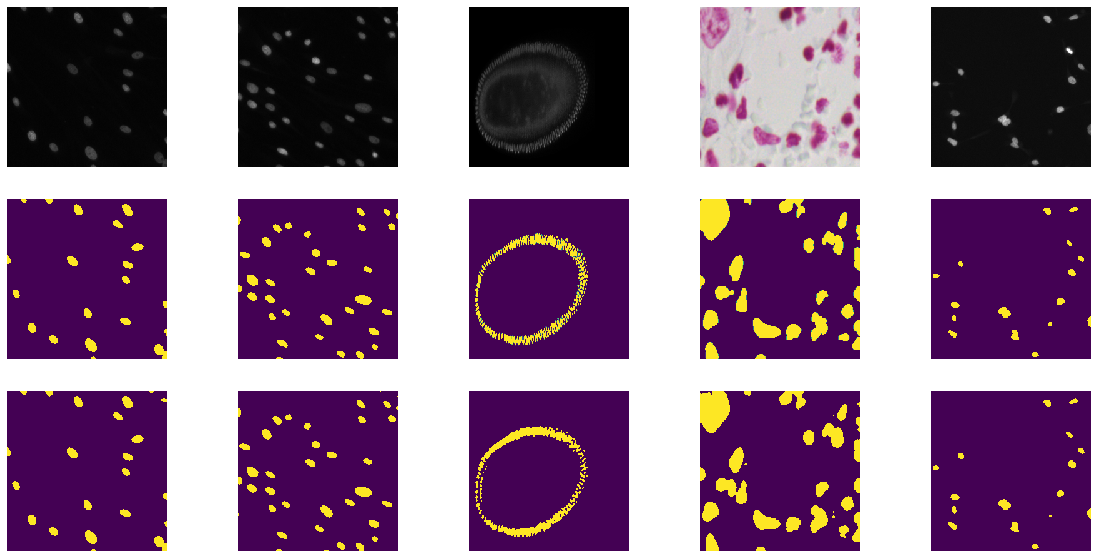

In [12]:
'''
    Plot images, ground truth masks and predicted masks
'''
predicted_masks_1 = np.array(predicted_masks > 0.5, dtype='uint8').reshape(BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1])
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(20,10))
i = 0
while i < 5:
    ax[0, i].imshow(sample_images[i])
    ax[1, i].imshow(ground_truth_masks[i])
    ax[2, i].imshow(predicted_masks_1[i])
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
    i += 1